In [3]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
#%matplotlib inline

In [4]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [18]:
# TensorFlow :
# first initialize the network variables and then network model

# clear old variables
tf.reset_default_graph()

# Setup input
# First dimension is none as it gets sets automatically when the first batch come in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X, y):
    
    # initialize the Two-Layer network
    # define the network weights and bais parameter
    Wconv1 = tf.get_variable("Wconv1", shape=[7,7,3,32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408,10])
    b1 = tf.get_variable("b1", shape=[10])
    
    # define the network graph (two-layer n/w)
    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding="VALID") + bconv1
    h1 = tf.nn.relu(conv1)
    h1_flat = tf.reshape(h1, [-1, 5408]) # to transform into a single vector
    y_out = tf.matmul(h1_flat, W1) + b1
    return y_out

y_out = simple_model(X, y)

# compute loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y, 10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# Optimize the loss function
optimizer = tf.train.AdamOptimizer(5e-4) # pass learning rate
train_step = optimizer.minimize(mean_loss)


Training
Iteration 0: with minibatch training loss = 7.7 and accuracy of 0.078
Iteration 100: with minibatch training loss = 1.08 and accuracy of 0.25
Iteration 200: with minibatch training loss = 0.654 and accuracy of 0.34
Iteration 300: with minibatch training loss = 0.695 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.497 and accuracy of 0.33
Iteration 500: with minibatch training loss = 0.495 and accuracy of 0.36
Iteration 600: with minibatch training loss = 0.507 and accuracy of 0.42
Iteration 700: with minibatch training loss = 0.399 and accuracy of 0.38
Epoch 1, Overall loss = 0.737 and accuracy of 0.319


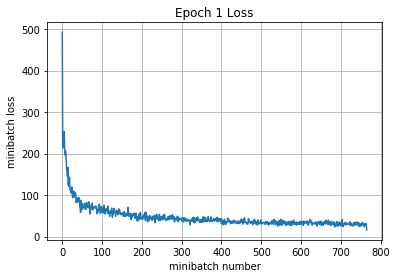

Validation
Epoch 1, Overall loss = 0.453 and accuracy of 0.361


In [19]:
# Training the model on one epoch
"""
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them 
input data and computing the results, we first need to create a tf.Session object. A session encapsulates 
the control and state of the TensorFlow runtime. For more information, see the TensorFlow Getting started guide.

Optionally we can also specify a device context such as /cpu:0 or /gpu:0. For documentation on this behavior 
see this TensorFlow guide

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below
"""

def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)
    
    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [39]:
# Training a specific model
"""
In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance 
(that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring 
your own model.

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with 
the following architecture:

    7x7 Convolutional Layer with 32 filters and stride of 1
    ReLU Activation Layer
    Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    2x2 Max Pooling layer with a stride of 2
    Affine layer with 1024 output units
    ReLU Activation Layer
    Affine layer from 1024 input units to 10 outputs
"""

# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32,32,3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool) 

def complex_model(X,y, is_training):
    
    # define network weight and bais parameters
    # Conv1
    Wconv1 = tf.get_variable("Wconv1", shape=[7,7,3,32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    
    #FC1
    W1 = tf.get_variable("W1", shape=[5408, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    
    #FC2
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])
    
    # define network graph
    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    activation_out = tf.nn.relu(conv1)
    #pool_out = tf.nn.max_pool(activation_out, [1,2,2,1], [1,2,2,1], 'SAME')
    batch_norm = tf.layers.batch_normalization(activation_out, axis=1, training=is_training)
    pool_out = tf.nn.max_pool(batch_norm, [1,2,2,1], [1,2,2,1], 'SAME')
    pool_out_flat = tf.reshape(pool_out, [-1,5408])
    affine_layer1 = tf.matmul(pool_out_flat , W1) + b1
    affine_reluact = tf.nn.relu(affine_layer1)
    y_out = tf.matmul(affine_reluact, W2) + b2
    return y_out
    

y_out = complex_model(X, y, is_training)    

In [ ]:
"""
To make sure you're doing the right thing, use the following tool to check the dimensionality of your output 
(it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10,
corresponding to our 10 classes):
"""

In [40]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        tf.global_variables_initializer().run()
        
        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

62.2 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


In [ ]:
#GPU!
"""
Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged 
and all our variables and operations will be computed using accelerated code paths. However, if there is no 
GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch
running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.
"""

try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()
            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

In [41]:
#Train the model.

"""
Now that you've seen how to define a model and do a single forward pass of some data through it, let's walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an RMSprop optimizer (using a 1e-3 learning rate) and a cross-entropy loss function. See the TensorFlow documentation for more information

    Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
    Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
"""
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
loss = tf.nn.softmax_cross_entropy_with_logits(labels=(tf.one_hot(y, 10)), logits=y_out)
mean_loss = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [42]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 40.2 and accuracy of 0.19
Iteration 100: with minibatch training loss = 2.11 and accuracy of 0.2
Iteration 200: with minibatch training loss = 2.08 and accuracy of 0.25
Iteration 300: with minibatch training loss = 1.99 and accuracy of 0.25
Iteration 400: with minibatch training loss = 1.86 and accuracy of 0.5
Iteration 500: with minibatch training loss = 1.53 and accuracy of 0.41
Iteration 600: with minibatch training loss = 1.64 and accuracy of 0.38
Iteration 700: with minibatch training loss = 1.49 and accuracy of 0.42
Epoch 1, Overall loss = 6.54 and accuracy of 0.339


(6.5402648356106816, 0.33883673469387754)

In [43]:
#Check the accuracy of the model.

"""
Let's see the train and test code in action -- feel free to use these methods when evaluating the models
you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

"""
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.47 and accuracy of 0.484


(1.4715232868194581, 0.48399999999999999)

In [ ]:
"""
Train a great model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model
that achieves >= 70% accuracy on the validation set of CIFAR-10. You can use the run_model function from above.
Things you should try:

    Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
    Number of filters: Above we used 32 filters. Do more or fewer do better?
    Pooling vs Strided Convolution: Do you use max pooling or just stride convolutions?
    Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch 
    normalization after affine layers. Do your networks train faster?
    Network architecture: The network above has two layers of trainable parameters. Can you do better with a 
    deep network? Good architectures to try include:
        [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
        [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
        [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
    Use TensorFlow Scope: Use TensorFlow scope and/or tf.layers to make it easier to write deeper networks. See 
    this tutorial for how to use tf.layers.
    Use Learning Rate Decay: As the notes point out, decaying the learning rate might help the model converge. 
    Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you 
    find appropriate. See the Tensorflow documentation for learning rate decay.
    Global Average Pooling: Instead of flattening and then having multiple affine layers, perform convolutions 
    until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image 
    picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in Google's Inception 
    Network (See Table 1 for their architecture).
    Regularization: Add l2 weight regularization, or perhaps use Dropout as in the TensorFlow MNIST tutorial

Tips for training

For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

    If the parameters are working well, you should see improvement within a few hundred iterations
    Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
    Once you have found some sets of parameters that seem to work, search more finely around these parameters. You 
    may need to train for more epochs.
    You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your 
    architecture on the best parameters as selected by the validation set.

Going above and beyond

If you are feeling adventurous there are many other features you can implement to try and improve your performance. 
You are not required to implement any of these; however they would be good things to try for extra credit.

    Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try 
    alternatives like AdaGrad or AdaDelta.
    Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
    Model ensembles
    Data augmentation
    New Architectures
        ResNets where the input from the previous layer is added to the output.
        DenseNets where inputs into previous layers are concatenated together.
        This blog has an in-depth overview

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.
What we expect

At the very least, you should be able to train a ConvNet that gets at >= 70% accuracy on the validation set. 
This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! 
Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain 
the training and validation set accuracies for your final trained network.

Have fun and happy training!

"""

In [61]:
def my_model(X, y, is_training, reg):
    
    # Conv-Relu-Batch_Normalization
    conv1_act = tf.layers.conv2d(inputs=X, kernel_size=3, filters=32, padding='SAME', strides=1, 
                                 activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm1 = tf.layers.batch_normalization(conv1_act, training=is_training)
    
    """ output tensor shape becomes [batch_size,32,32,32(# of filters)] """
    
    # Conv-Relu-Batch_Normalization
    conv2_act = tf.layers.conv2d(inputs=batch_norm1, filters=64, kernel_size=3, padding='SAME', strides=1, 
                                 activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    #conv2_act = tf.layers.conv2d(inputs=conv1_act, filters=64, kernel_size=3, padding='SAME', strides=1, activation=tf.nn.relu)
    batch_norm2 = tf.layers.batch_normalization(conv2_act, training=is_training)
    
    """output tensor shape becomes [batch_size, 32,32,64] """
    
    # MaxPool
    max_pool1 = tf.layers.max_pooling2d(batch_norm2, pool_size=2, strides=2)
    #max_pool1 = tf.layers.max_pooling2d(conv2_act, pool_size=2, strides=2)
    
    """ output tensor shape becomes [batch_size, 16,16,64] """
    
    # flatten : will flatten our feature map (max_pool1) to shape [batch_size, features]
    # [batch_size = -1, features = 16 * 16 * 64]
    flatten1 = tf.reshape(max_pool1, [-1, 16384])
    
    #FC-Relu-BN
    fc1 = tf.layers.dense(flatten1, units=1024, activation=tf.nn.relu) # units = number of neurons in dense layer
    batch_norm3 = tf.layers.batch_normalization(fc1, training=is_training)
    
    # FC_out
    y_out = tf.layers.dense(batch_norm3, units=10, activation=None)
    
    return y_out

# clear tensor flow variable
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X, y, is_training, 5e-3)
mean_loss = None
optimizer = None

mean_loss = tf.losses.softmax_cross_entropy(logits=y_out, onehot_labels=tf.one_hot(y, 10))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.74 and accuracy of 0.2
Iteration 100: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 200: with minibatch training loss = 1.36 and accuracy of 0.48
Iteration 300: with minibatch training loss = 1.37 and accuracy of 0.53
Iteration 400: with minibatch training loss = 0.976 and accuracy of 0.67
Iteration 500: with minibatch training loss = 1.14 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.1 and accuracy of 0.61
Iteration 700: with minibatch training loss = 0.847 and accuracy of 0.67
Epoch 1, Overall loss = 1.3 and accuracy of 0.566


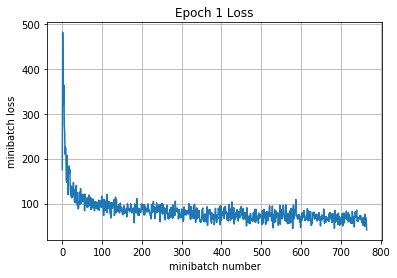

Iteration 800: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 900: with minibatch training loss = 0.954 and accuracy of 0.69
Iteration 1000: with minibatch training loss = 0.849 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 0.936 and accuracy of 0.67
Iteration 1200: with minibatch training loss = 0.655 and accuracy of 0.84
Iteration 1300: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 0.737 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.627 and accuracy of 0.69
Epoch 2, Overall loss = 0.828 and accuracy of 0.713


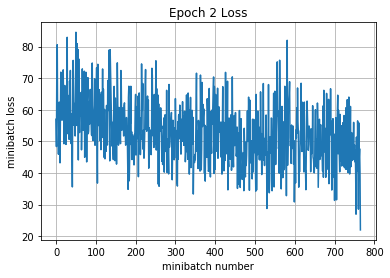

Iteration 1600: with minibatch training loss = 0.629 and accuracy of 0.77
Iteration 1700: with minibatch training loss = 0.649 and accuracy of 0.8
Iteration 1800: with minibatch training loss = 0.417 and accuracy of 0.83
Iteration 1900: with minibatch training loss = 0.536 and accuracy of 0.83
Iteration 2000: with minibatch training loss = 0.409 and accuracy of 0.84
Iteration 2100: with minibatch training loss = 0.687 and accuracy of 0.8
Iteration 2200: with minibatch training loss = 0.483 and accuracy of 0.81
Epoch 3, Overall loss = 0.573 and accuracy of 0.803


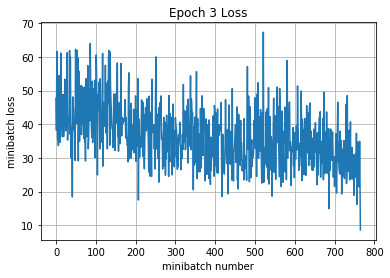

Iteration 2300: with minibatch training loss = 0.807 and accuracy of 0.78
Iteration 2400: with minibatch training loss = 0.424 and accuracy of 0.88
Iteration 2500: with minibatch training loss = 0.404 and accuracy of 0.8
Iteration 2600: with minibatch training loss = 0.27 and accuracy of 0.89
Iteration 2700: with minibatch training loss = 0.246 and accuracy of 0.91
Iteration 2800: with minibatch training loss = 0.346 and accuracy of 0.88
Iteration 2900: with minibatch training loss = 0.206 and accuracy of 0.98
Iteration 3000: with minibatch training loss = 0.158 and accuracy of 0.94
Epoch 4, Overall loss = 0.309 and accuracy of 0.898


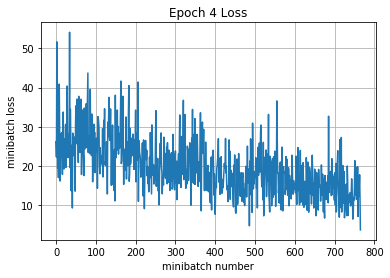

Iteration 3100: with minibatch training loss = 0.228 and accuracy of 0.92
Iteration 3200: with minibatch training loss = 0.13 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.102 and accuracy of 0.97
Iteration 3400: with minibatch training loss = 0.079 and accuracy of 0.98
Iteration 3500: with minibatch training loss = 0.089 and accuracy of 0.98
Iteration 3600: with minibatch training loss = 0.0877 and accuracy of 0.98
Iteration 3700: with minibatch training loss = 0.0622 and accuracy of 0.98
Iteration 3800: with minibatch training loss = 0.0877 and accuracy of 0.97
Epoch 5, Overall loss = 0.149 and accuracy of 0.952


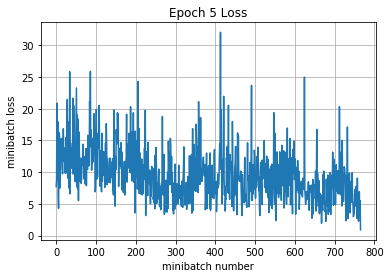

Iteration 3900: with minibatch training loss = 0.0839 and accuracy of 0.97
Iteration 4000: with minibatch training loss = 0.0923 and accuracy of 0.98
Iteration 4100: with minibatch training loss = 0.0616 and accuracy of 0.98
Iteration 4200: with minibatch training loss = 0.155 and accuracy of 0.95
Iteration 4300: with minibatch training loss = 0.15 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.058 and accuracy of 1
Iteration 4500: with minibatch training loss = 0.0974 and accuracy of 0.97
Epoch 6, Overall loss = 0.102 and accuracy of 0.968


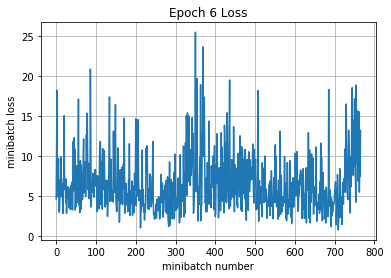

Iteration 4600: with minibatch training loss = 0.14 and accuracy of 0.92
Iteration 4700: with minibatch training loss = 0.129 and accuracy of 0.98
Iteration 4800: with minibatch training loss = 0.0831 and accuracy of 0.97
Iteration 4900: with minibatch training loss = 0.0744 and accuracy of 0.97
Iteration 5000: with minibatch training loss = 0.0372 and accuracy of 0.98
Iteration 5100: with minibatch training loss = 0.0629 and accuracy of 0.97
Iteration 5200: with minibatch training loss = 0.0616 and accuracy of 0.97
Iteration 5300: with minibatch training loss = 0.0282 and accuracy of 1
Epoch 7, Overall loss = 0.0879 and accuracy of 0.97


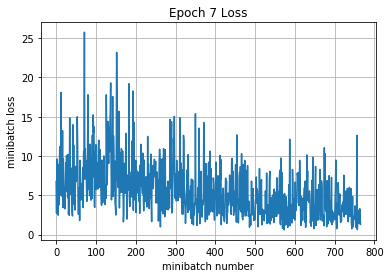

Iteration 5400: with minibatch training loss = 0.031 and accuracy of 1
Iteration 5500: with minibatch training loss = 0.0613 and accuracy of 0.98
Iteration 5600: with minibatch training loss = 0.031 and accuracy of 1
Iteration 5700: with minibatch training loss = 0.0516 and accuracy of 0.98
Iteration 5800: with minibatch training loss = 0.0352 and accuracy of 1
Iteration 5900: with minibatch training loss = 0.209 and accuracy of 0.95
Iteration 6000: with minibatch training loss = 0.0861 and accuracy of 0.97
Iteration 6100: with minibatch training loss = 0.0148 and accuracy of 1
Epoch 8, Overall loss = 0.0613 and accuracy of 0.981


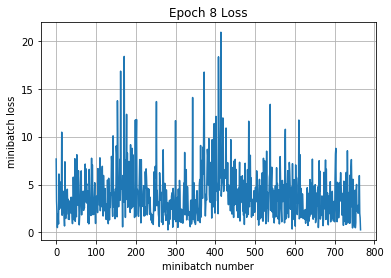

Iteration 6200: with minibatch training loss = 0.0546 and accuracy of 0.98
Iteration 6300: with minibatch training loss = 0.0966 and accuracy of 0.97
Iteration 6400: with minibatch training loss = 0.044 and accuracy of 0.98
Iteration 6500: with minibatch training loss = 0.0161 and accuracy of 0.98
Iteration 6600: with minibatch training loss = 0.00941 and accuracy of 1
Iteration 6700: with minibatch training loss = 0.0754 and accuracy of 0.97
Iteration 6800: with minibatch training loss = 0.00839 and accuracy of 1
Epoch 9, Overall loss = 0.0607 and accuracy of 0.98


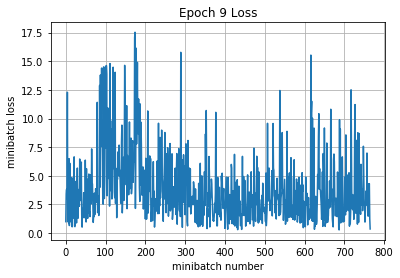

Iteration 6900: with minibatch training loss = 0.0514 and accuracy of 0.98
Iteration 7000: with minibatch training loss = 0.0744 and accuracy of 0.97
Iteration 7100: with minibatch training loss = 0.0182 and accuracy of 1
Iteration 7200: with minibatch training loss = 0.0357 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.0635 and accuracy of 0.95
Iteration 7400: with minibatch training loss = 0.0197 and accuracy of 1
Iteration 7500: with minibatch training loss = 0.0257 and accuracy of 0.98
Iteration 7600: with minibatch training loss = 0.00748 and accuracy of 1
Epoch 10, Overall loss = 0.0342 and accuracy of 0.989


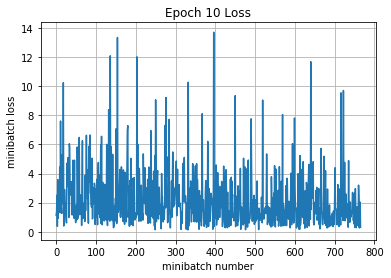

Validation
Epoch 1, Overall loss = 1.64 and accuracy of 0.703


(1.6428049726486207, 0.70299999999999996)

In [62]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [63]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.64 and accuracy of 0.7


(1.6395417826652527, 0.69999999999999996)

In [ ]:
"""

# just a experiment

import tensorflow as tf
import numpy as np
# clear previous variables
tf.reset_default_graph()

# define input and output
# at run time it decides number of training examples
X = tf.placeholder(tf.float32, [None, 32,32,3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def ConvNet_model_fn(X, y, is_training, reg):
    
    # define network graph
    # conv1-leaky_relu-BN-pool
    conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=5, padding='same', activation=tf.nn.leaky_relu, 
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm1 = tf.layers.batch_normalization(inputs=conv1, training=is_training)
    pool1 = tf.layers.max_pooling2d(inputs=batch_norm1, pool_size=2, strides=2)
    
    # conv2-leaky_relu-BN-pool
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=3, padding='same', activation=tf.nn.leaky_relu, 
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm2 = tf.layers.batch_normalization(inputs=conv2, training=is_training)
    pool2 = tf.layers.max_pooling2d(inputs=batch_norm2, pool_size=2, strides=2)
    
    # conv3-leaky_relu-BN-pool
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=3, padding='same', activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm3 = tf.layers.batch_normalization(inputs=conv3, training=is_training)
    pool3 = tf.layers.max_pooling2d(inputs=batch_norm3, pool_size=2, strides=2)
    
    # conv4-leaky_relu-BN-pool
    conv4 = tf.layers.conv2d(inputs=pool3, filters=128, kernel_size=3, padding='same', activation=tf.nn.relu, 
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm4 = tf.layers.batch_normalization(inputs=conv4, training=is_training)
    pool4 = tf.layers.max_pooling2d(inputs=batch_norm4, pool_size=2, strides=2)
    
    # conv5-leaky_relu-BN-pool
    conv5 = tf.layers.conv2d(inputs=pool4, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(reg))
    batch_norm5 = tf.layers.batch_normalization(inputs=conv5, training=is_training)
    pool5 = tf.layers.max_pooling2d(inputs=batch_norm5, pool_size=2, strides=2)
    
    # FC1
    # will flatten our activation map (pool5) to shape [batch_size, features]
    pool5_flat = tf.reshape(pool5, [-1, pool_height*pool_width*pool_channels])
    
    # dense layer
    FC1 = tf.layers.dense(inputs=pool5_flat, units=1024, activation=tf.nn.leaky_relu)
    
    # Dropout layer
    dropout = tf.layers.dropout(inputs=FC1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # logits layer
    y_out = tf.layers.dense(inputs=dropout, units=10, activation=None)
    
    return y_out

y_out = ConvNet_model_fn(X, y, is_training, 0.001)
    
loss = tf.losses.sparse_softmax_cross_entropy(labels=tf.one_hot(y, 10), logits=y_out)

optimizer = tf.train.AdamOptimizer(1e-3)
train_step = optimizer.minimize(loss)

# Add evaluation matrics
eval_metric = {
    accuracy : tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric=eval_metric)
}

"""